<a href="https://colab.research.google.com/github/MPGarg/Assignment-8/blob/main/EVA8_Assigment_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
from __future__ import print_function
import torch.optim as optim
from torchvision import datasets, transforms
import torch
import torch.nn.functional as F
import torchvision
from torchsummary import summary
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
#!pip install -U albumentations
!pip install torch_lr_finder
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch_lr_finder import LRFinder

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Import files from GIT Hub

In [3]:
!git clone https://github.com/MPGarg/main_repo.git

Cloning into 'main_repo'...
remote: Enumerating objects: 85, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 85 (delta 14), reused 0 (delta 0), pack-reused 52
Unpacking objects: 100% (85/85), 32.05 KiB | 482.00 KiB/s, done.


# Custom ResNet class is imported

In [4]:
from main_repo.models import custom_resnet
from main_repo.models.custom_resnet import Custom_ResNet

# Import Other fuctions

In [5]:
from main_repo import main, utils
from main_repo.utils import *    
from main_repo.main import train, test, fit_model

# Assign device

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [7]:
view_model = Custom_ResNet().to(device)
summary(view_model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         Dropout2d-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 32, 32]          73,728
         MaxPool2d-6          [-1, 128, 16, 16]               0
       BatchNorm2d-7          [-1, 128, 16, 16]             256
              ReLU-8          [-1, 128, 16, 16]               0
         Dropout2d-9          [-1, 128, 16, 16]               0
           Conv2d-10          [-1, 128, 16, 16]         147,456
      BatchNorm2d-11          [-1, 128, 16, 16]             256
             ReLU-12          [-1, 128, 16, 16]               0
        Dropout2d-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 128,

# Show sample images and Load dataset

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


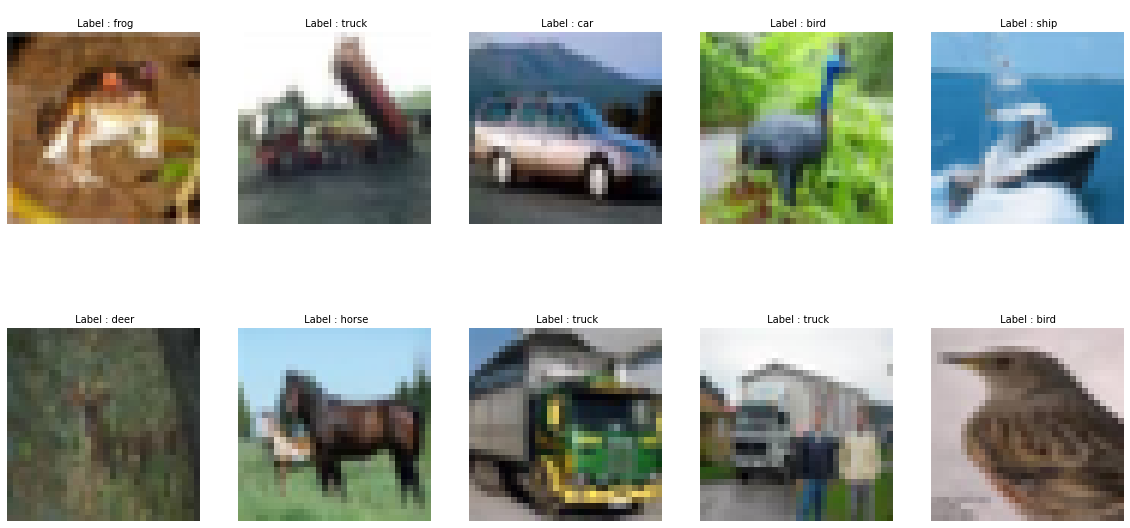

In [8]:
trainset_mod, trainloader_mod, testset_mod, testloader_mod,mean, std = process_dataset(visualize = 'X')     

In [9]:
print(mean)
print(std)

[0.4914, 0.4822, 0.4465]
[0.247, 0.2435, 0.2616]


# Find Learning Rate

  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.41E-01


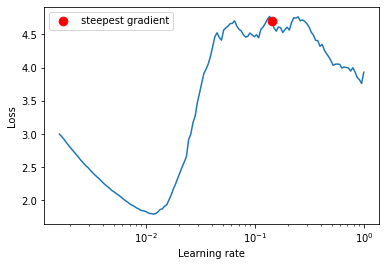

(<matplotlib.axes._subplots.AxesSubplot at 0x7f7a83f1c100>, 0.1414991297434576)

In [10]:
import copy
model = Custom_ResNet().to(device)
model_exp = copy.deepcopy(model)
optimizer = torch.optim.SGD(model_exp.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()
lr_finder = LRFinder(model_exp, optimizer, criterion, device=device)
lr_finder.range_test(trainloader_mod, end_lr=10, num_iter=200)
lr_finder.plot() 

In [11]:
min_loss = min(lr_finder.history['loss'])
ler_rate = lr_finder.history['lr'][np.argmin(lr_finder.history['loss'], axis=0)]
print("Max LR is {}".format(ler_rate))

Max LR is 0.011623224686798524


# Train & Test Model

In [12]:
#model = Custom_ResNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=ler_rate/10, momentum=0.9)
#max_lr is the maximum learning rate of OneCycleLR 
#the learning rate will increase from max_lr / div_factor to max_lr in the first pct_start * total_steps steps, 
#and decrease smoothly to max_lr / final_div_factor then.
#total_steps = epochs * steps_per_epoch
#total_steps = 24 * 98 = 2,352
#max_lr / div_factor = 0.01 / 10 = 0.001
#pct_start * total_steps = 0.002 * 2,352 = 4.704
#max_lr / final_div_factor = 0.01 / 100 = 0.00001
#final_div_factor (float) – Determines the minimum learning rate via min_lr = initial_lr/final_div_factor

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                max_lr=ler_rate,
                                                steps_per_epoch=len(trainloader_mod), 
                                                epochs=24,
                                                pct_start=0.002,
                                                div_factor=8,
                                                three_phase=False, 
                                                #final_div_factor=1000,
                                                anneal_strategy='linear'
                                                ) 

model_tr, wrong_prediction_list, right_prediction_list, train_losses, train_acc, test_losses, test_acc = fit_model(
                                                    model=model, 
                                                    device=device,
                                                    trainloader=trainloader_mod, 
                                                    testloader=testloader_mod,
                                                    criterion = nn.CrossEntropyLoss(),
                                                    EPOCHS=24,
                                                    optimizer=optimizer,
                                                    scheduler=scheduler
                                                    
                                                )

EPOCH: 1 (LR: 0.0014529030858498155)


100%|██████████| 98/98 [00:26<00:00,  3.73it/s]


Average Training Loss=0.003260360567569733, Accuracy=41.54


Test set: Average loss: 0.0023, Accuracy: 5893/10000 (58.93%)

EPOCH: 2 (LR: 0.0034911270467761412)


100%|██████████| 98/98 [00:26<00:00,  3.76it/s]


Average Training Loss=0.0020603844332695007, Accuracy=62.564


Test set: Average loss: 0.0019, Accuracy: 6655/10000 (66.55%)

EPOCH: 3 (LR: 0.005529351007702467)


100%|██████████| 98/98 [00:25<00:00,  3.83it/s]


Average Training Loss=0.0016328199195861817, Accuracy=70.456


Test set: Average loss: 0.0016, Accuracy: 7265/10000 (72.65%)

EPOCH: 4 (LR: 0.007567574968628793)


100%|██████████| 98/98 [00:25<00:00,  3.80it/s]


Average Training Loss=0.001350446366071701, Accuracy=75.888


Test set: Average loss: 0.0015, Accuracy: 7512/10000 (75.12%)

EPOCH: 5 (LR: 0.009605798929555119)


100%|██████████| 98/98 [00:25<00:00,  3.80it/s]


Average Training Loss=0.0012036595726013183, Accuracy=78.64


Test set: Average loss: 0.0013, Accuracy: 7865/10000 (78.65%)

EPOCH: 6 (LR: 0.011616982431483545)


100%|██████████| 98/98 [00:25<00:00,  3.82it/s]


Average Training Loss=0.0010293686252832413, Accuracy=81.922


Test set: Average loss: 0.0012, Accuracy: 8016/10000 (80.16%)

EPOCH: 7 (LR: 0.011005241410615653)


100%|██████████| 98/98 [00:25<00:00,  3.80it/s]


Average Training Loss=0.0008567275822162628, Accuracy=84.726


Test set: Average loss: 0.0011, Accuracy: 8136/10000 (81.36%)

EPOCH: 8 (LR: 0.010393500389747762)


100%|██████████| 98/98 [00:25<00:00,  3.80it/s]


Average Training Loss=0.0007562841492891312, Accuracy=86.542


Test set: Average loss: 0.0011, Accuracy: 8194/10000 (81.94%)

EPOCH: 9 (LR: 0.00978175936887987)


100%|██████████| 98/98 [00:25<00:00,  3.82it/s]


Average Training Loss=0.0006411626678705215, Accuracy=88.526


Test set: Average loss: 0.0012, Accuracy: 8087/10000 (80.87%)

EPOCH: 10 (LR: 0.009170018348011979)


100%|██████████| 98/98 [00:25<00:00,  3.79it/s]


Average Training Loss=0.0005792523699998856, Accuracy=89.814


Test set: Average loss: 0.0009, Accuracy: 8473/10000 (84.73%)

EPOCH: 11 (LR: 0.008558277327144087)


100%|██████████| 98/98 [00:25<00:00,  3.81it/s]


Average Training Loss=0.000523533521592617, Accuracy=90.77


Test set: Average loss: 0.0009, Accuracy: 8591/10000 (85.91%)

EPOCH: 12 (LR: 0.007946536306276196)


100%|██████████| 98/98 [00:25<00:00,  3.83it/s]


Average Training Loss=0.0004478743827342987, Accuracy=92.13


Test set: Average loss: 0.0010, Accuracy: 8461/10000 (84.61%)

EPOCH: 13 (LR: 0.0073347952854083045)


100%|██████████| 98/98 [00:25<00:00,  3.83it/s]


Average Training Loss=0.0004032653298974037, Accuracy=92.912


Test set: Average loss: 0.0009, Accuracy: 8693/10000 (86.93%)

EPOCH: 14 (LR: 0.006723054264540413)


100%|██████████| 98/98 [00:25<00:00,  3.80it/s]


Average Training Loss=0.0003486139549314976, Accuracy=93.91


Test set: Average loss: 0.0009, Accuracy: 8663/10000 (86.63%)

EPOCH: 15 (LR: 0.0061113132436725216)


100%|██████████| 98/98 [00:25<00:00,  3.83it/s]


Average Training Loss=0.0003066498090326786, Accuracy=94.666


Test set: Average loss: 0.0008, Accuracy: 8727/10000 (87.27%)

EPOCH: 16 (LR: 0.00549957222280463)


100%|██████████| 98/98 [00:25<00:00,  3.79it/s]


Average Training Loss=0.00026869053065776825, Accuracy=95.428


Test set: Average loss: 0.0008, Accuracy: 8701/10000 (87.01%)

EPOCH: 17 (LR: 0.004887831201936739)


100%|██████████| 98/98 [00:26<00:00,  3.64it/s]


Average Training Loss=0.0002387345352768898, Accuracy=96.0


Test set: Average loss: 0.0008, Accuracy: 8783/10000 (87.83%)

EPOCH: 18 (LR: 0.004276090181068847)


100%|██████████| 98/98 [00:27<00:00,  3.61it/s]


Average Training Loss=0.00021420243859291078, Accuracy=96.484


Test set: Average loss: 0.0008, Accuracy: 8775/10000 (87.75%)

EPOCH: 19 (LR: 0.003664349160200954)


100%|██████████| 98/98 [00:25<00:00,  3.83it/s]


Average Training Loss=0.00019922693833708763, Accuracy=96.774


Test set: Average loss: 0.0008, Accuracy: 8813/10000 (88.13%)

EPOCH: 20 (LR: 0.0030526081393330642)


100%|██████████| 98/98 [00:25<00:00,  3.79it/s]


Average Training Loss=0.00017526239089667796, Accuracy=97.114


Test set: Average loss: 0.0008, Accuracy: 8824/10000 (88.24%)

EPOCH: 21 (LR: 0.002440867118465171)


100%|██████████| 98/98 [00:25<00:00,  3.81it/s]


Average Training Loss=0.0001578989128023386, Accuracy=97.472


Test set: Average loss: 0.0007, Accuracy: 8903/10000 (89.03%)

EPOCH: 22 (LR: 0.0018291260975972813)


100%|██████████| 98/98 [00:25<00:00,  3.83it/s]


Average Training Loss=0.00013838313214480877, Accuracy=97.902


Test set: Average loss: 0.0007, Accuracy: 8908/10000 (89.08%)

EPOCH: 23 (LR: 0.0012173850767293881)


100%|██████████| 98/98 [00:25<00:00,  3.79it/s]


Average Training Loss=0.0001229805303364992, Accuracy=98.168


Test set: Average loss: 0.0007, Accuracy: 8923/10000 (89.23%)

EPOCH: 24 (LR: 0.0006056440558614984)


100%|██████████| 98/98 [00:25<00:00,  3.79it/s]


Average Training Loss=0.00011229226991534233, Accuracy=98.296


Test set: Average loss: 0.0007, Accuracy: 8943/10000 (89.43%)

Total Number of incorrectly predicted images by model is 1057


# Display Validation Accuracy & Loss

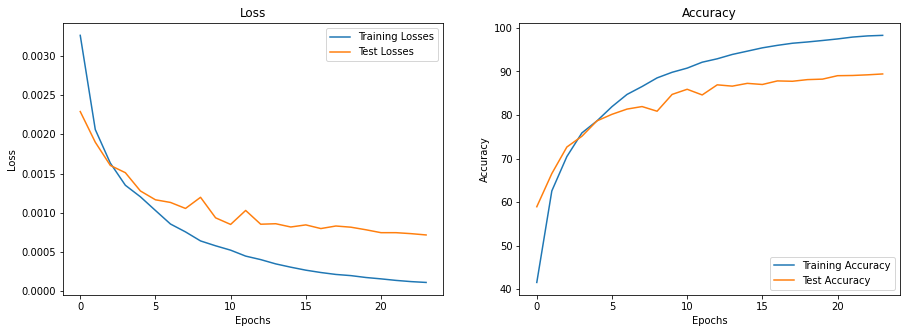

In [13]:
plot_acc_loss(train_acc,train_losses,test_acc,test_losses)

# Display wrong prediction

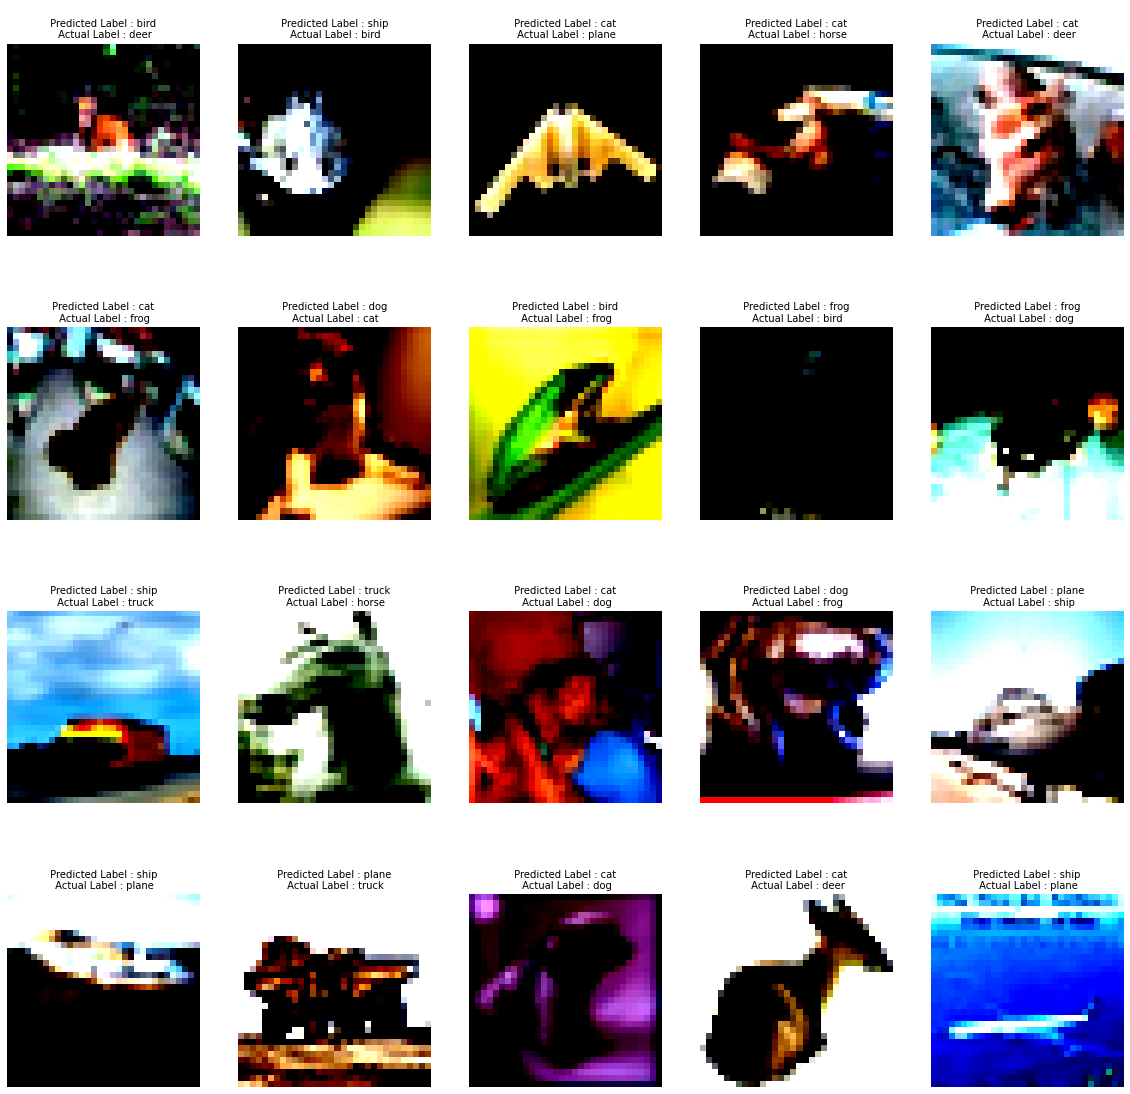

In [14]:
display_incorrect_pred(wrong_prediction_list)

# GradCam 

In [15]:
target_layers = ["layer1", "layer2","layer3"]
torch.autograd.set_detect_anomaly(True)

In [16]:
from main_repo.utils import generate_gradcam, plot_gradcam
gradcam_output, probs, predicted_classes = generate_gradcam(wrong_prediction_list[:10], model_tr, target_layers, device)

torch.Size([10, 10])
Generating Grad-CAM @layer1
Generating Grad-CAM @layer2
Generating Grad-CAM @layer3


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


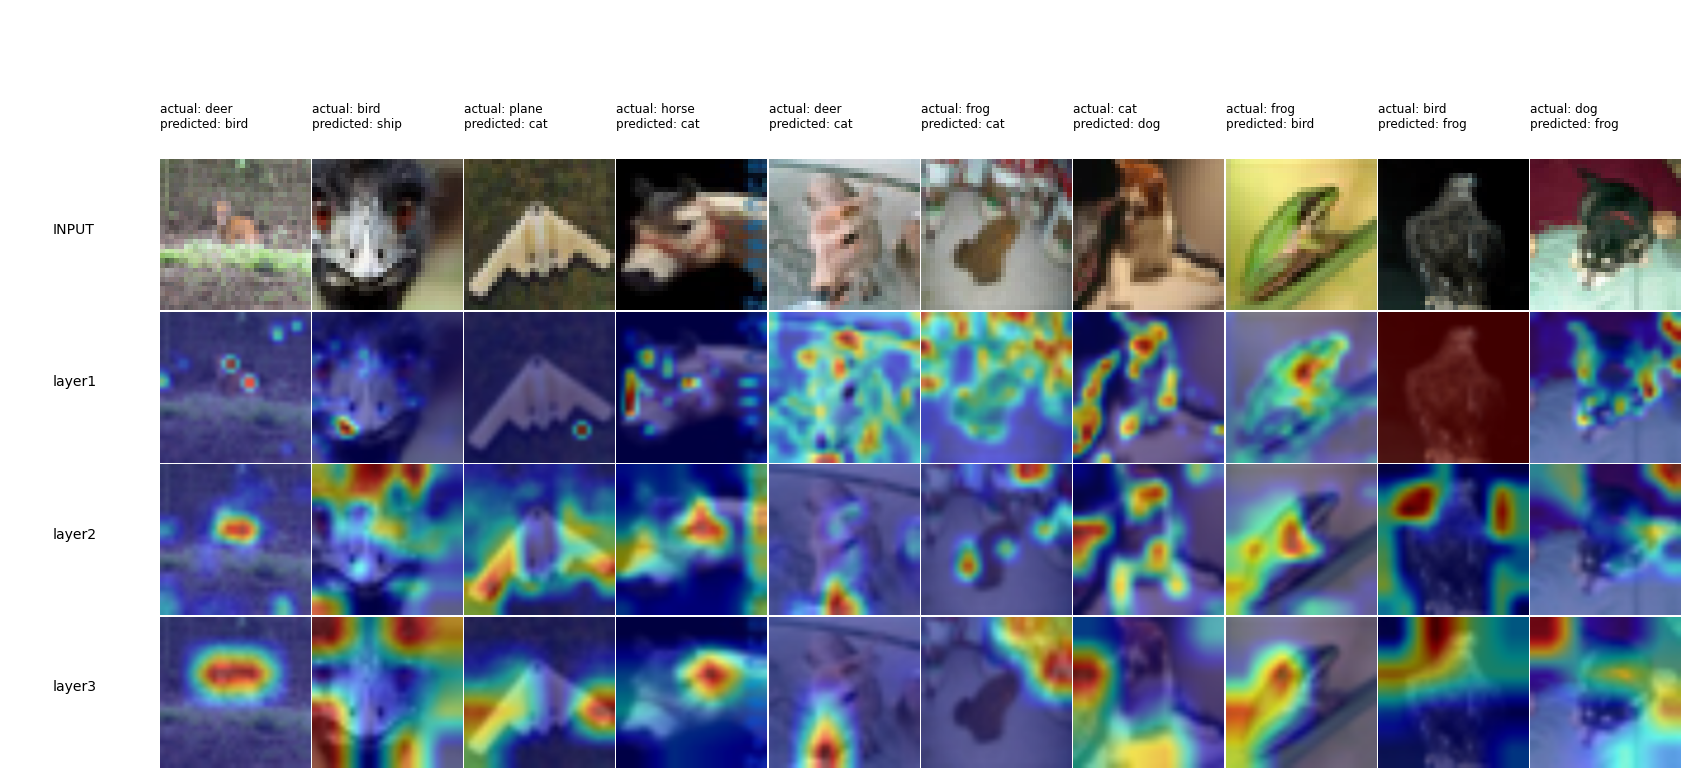

In [17]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
plot_gradcam(gradcam_output, target_layers, classes, (3,32,32), predicted_classes, wrong_prediction_list[:10],mean,std)

In [18]:
gradcam_output, probs, predicted_classes = generate_gradcam(right_prediction_list[:10], model_tr, target_layers, device)

torch.Size([10, 10])
Generating Grad-CAM @layer1
Generating Grad-CAM @layer2
Generating Grad-CAM @layer3


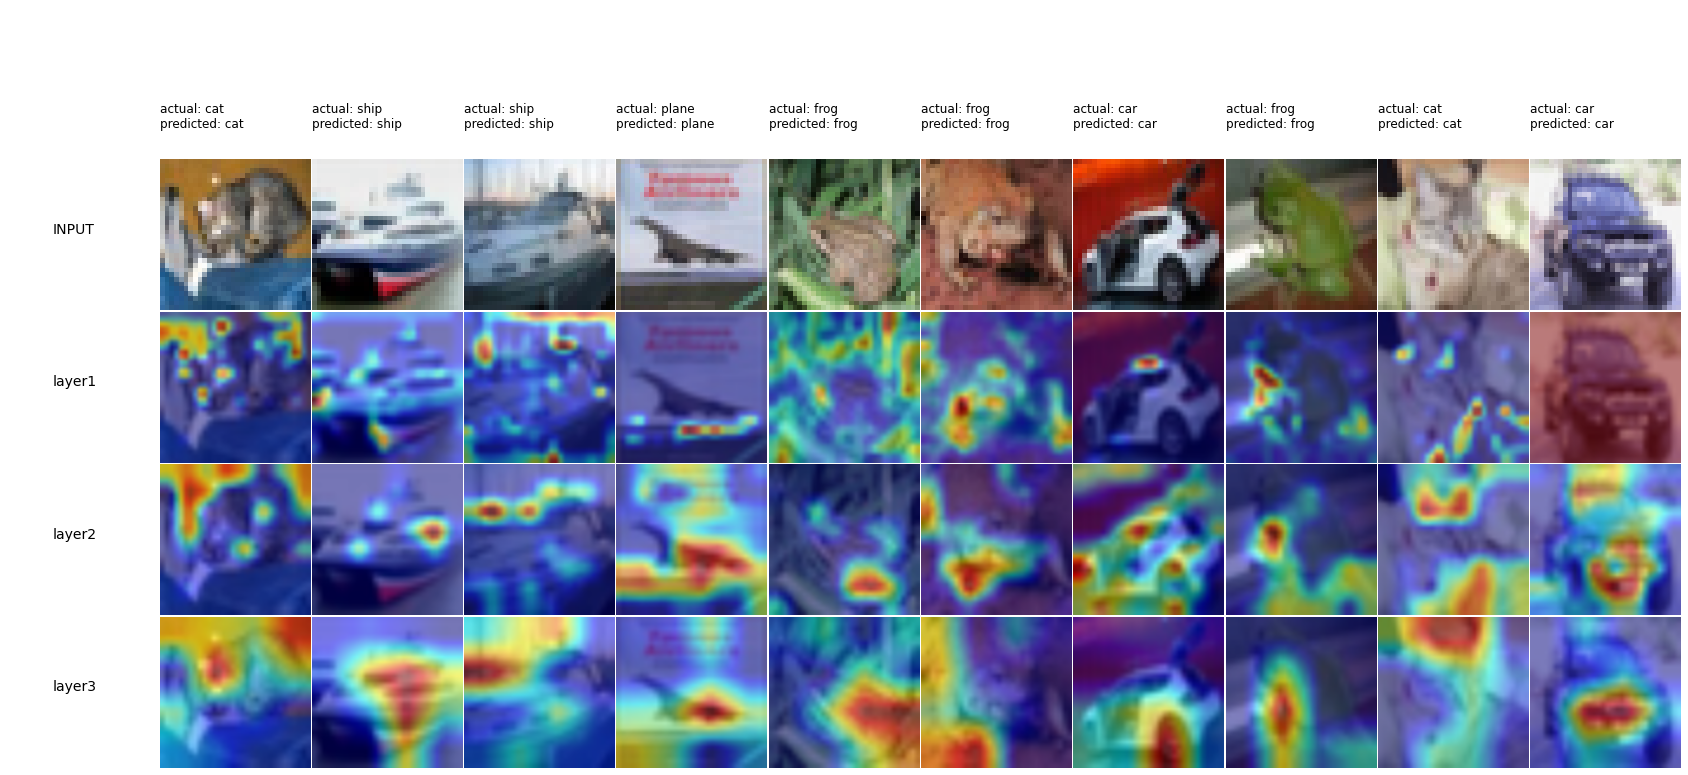

In [19]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
plot_gradcam(gradcam_output, target_layers, classes, (3,32,32), predicted_classes, right_prediction_list[:10],mean,std)